## TASK 3 - Scene recognition with Bag of Visual Words

Group Number: #INSERT HERE


### 1 Data import and Preparation

Complete the class ***SceneDataset*** in ***dataset.py*** and load the training and test dataset. (images and class labels)

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport features, dataset, utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import numpy as np
import features
import dataset
import utils
import os

In [2]:
if not os.path.exists(os.path.join(os.getcwd(), 'results')):
    os.makedirs(os.path.join(os.getcwd(), 'results'))

#student_code start

# Init datasets
train_path = "./data/scene/train/"
test_path =  "./data/scene/test/"
train_dataset = dataset.SceneDataset(train_path)
test_dataset = dataset.SceneDataset(test_path)

# Get images and class names
train_images = train_dataset.get_data()[0]
test_images = test_dataset.get_data()[0]
class_names = test_dataset.get_class_names()[0]

#student_code end

print('Imported test data: ',len(test_images))
print('Imported training data: ', len(train_images))
print(class_names)


Imported test data:  400
Imported training data:  1600
['forest', 'bedroom', 'office', 'coast', 'tallbuilding', 'street', 'livingroom', 'mountain', 'kitchen', 'store']


###  2 Build Vocabulary and Clusters

Extract SIFT features from the training data using ***features.extract_dsift(..)*** and then utilize the descriptors to generate visual words with ***KMeans(...).fit(...).cluster_centers_*** from ***sklearn.neighbors***. Set the sample size per image at about **100** and a step size around **5**. For cluster size, try a value around **50**. You can adapt the paramater to achieve better results. If clustering takes too long, have a look at the parameters **n_init** and **max_iter** of ***KMeans(...)***.

_***HINT:***_
***KMeans(..)*** expects the features to be a stacked 2D matrix instead of a list (np.vstack(...)).


In [3]:
#student code start

# (For train images:)
# Compute descriptors (dense-sift) for grid with stepsize 5
train_descriptors_1 = np.array(features.extract_dsift(train_images, stepsize=5, num_samples=100))

# Find clusters and cluster centers
train_clusters = KMeans(n_clusters=50).fit(np.vstack(train_descriptors_1)).cluster_centers_

#student code end

DSIFT Extraction: {0.7927160419999999}  seconds


###  3 Classification

Generate a histogram per image using the centroids. First extract the dense SIFT features of the training set again. This time use a smaller stepsize (eg. 1 or 2) and take all samples.

After, implement ***count_visual_words(..)*** in ***features.py*** to obtain a histogram per image. Build a kNN classifier with ***KNeighborsClassifier(..)*** and fit the the model with the histogram data of the training images and training labels. Set the neighbourhood size to **3**.


In [4]:
#student code start

# (For train images:)
# Compute descriptors (dense-sift) for grid with stepsize 2
train_descriptors_2 = np.array(features.extract_dsift(train_images, stepsize=2))
# Generate histograms
train_histograms = features.count_visual_words(train_descriptors_2, train_clusters)

# Fit histograms to classes (to annotated data)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_histograms, train_dataset.get_data()[1])

#student code end

DSIFT Extraction: {3.214552917000006}  seconds
Counting visual words: {12.456360165999996}  seconds


KNeighborsClassifier(n_neighbors=3)

### 4 Evaluation

Examine the accuracy of your model by extracting the dense SIFT points of the test set with the same stepsize as before, generate the histogams and predict the labels of the test set with the previously fitted classifier. Plot your results with ***utils.plot_confusion_matrix(..)***.

_***HINT:***_
Use the methods ***predict(..)*** and ***score(..)*** on the KNN classifier.


***Submission:*** Save the confusion matrix with the KNN score as **task3_accuracy_test_data.png** using ***utils.plot_confusion_matrix(..)***.



DSIFT Extraction: {0.6270929580000484}  seconds
Counting visual words: {3.08348541700002}  seconds


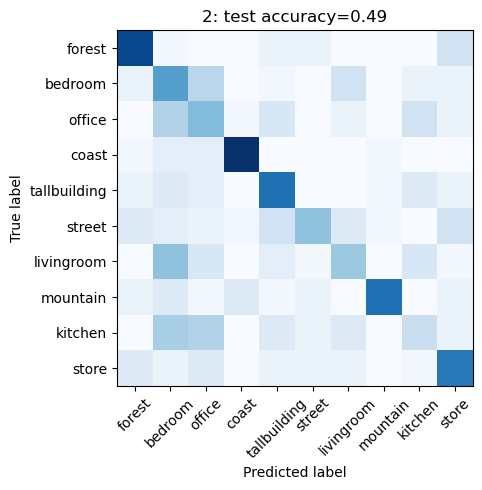

In [34]:
#student code start

# (For test images:)
# Compute descriptors (dense-sift) for grid with stepsize 2
test_descriptors = np.array(features.extract_dsift(test_images, stepsize=2))
# Generate histograms
test_histograms = features.count_visual_words(test_descriptors, train_clusters)

# Get predictions for histograms and predictions scores (mean accuracy)
test_label_predictions = neigh.predict(test_histograms)
test_label_scores = neigh.score(test_histograms, test_dataset.get_data()[1])

utils.plot_confusion_matrix(test_dataset.get_data()[1], test_label_predictions, test_label_scores, class_names, group_no=2, name="task3_accuracy_test_data.png")

#student code end

***
#### Q1: Analyze the confusion matrix. Are there classes which can be more easily identified than others. What could be the reason? What classes perform worst, and explain your answer.


Forest, Coast and Tallbuilding are recognized the best, we suppose because they have unique visual-words (e.g. leafs, sea/horizon, windows). Classes which are semantically close (e.g. indoor) like bedroom, livingroom and kitchen share alot of common visual-words (e.g. chairs, tables, fabrics).


Take some own test images and investigate if they can be correctly classified with you trained model. For instance, take a photo of your own kitchen or living room and classify it. You should at least test one photo from three of the ten categories. Make sure the images are resized and cropped to 100x100.

***Submission:*** Save the confusion matrix with the model score as **task3_accuracy_custom_data.png** using ***utils.plot_confusion_matrix(..)***.

DSIFT Extraction: {0.02273808299992197}  seconds
Counting visual words: {0.07421991699993669}  seconds


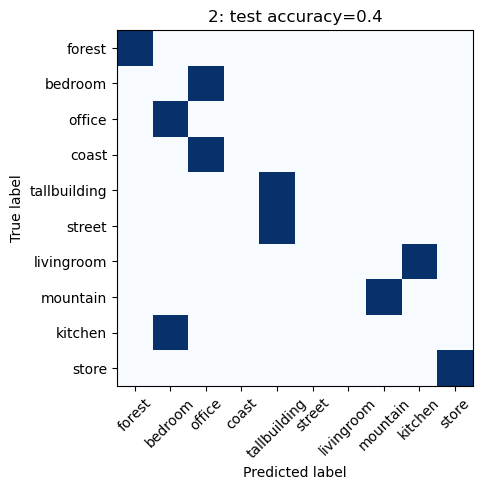

In [46]:
#student_code start

import cv2

# Load test dataset
test_path =  "./data/custom/"
test_dataset_o = dataset.SceneDataset(test_path)
test_images_o = test_dataset_o.get_data()[0]
test_labels_o = test_dataset_o.get_data()[1]
class_names_o = test_dataset_o.get_class_names()[0]

# Make images square and grayscale
square_images_o = []
i = 0
for image in test_images_o:
    h, w = image.shape
    s = min(h, w)
    crop_img = image[0:s, 0:s]
    crop_img = cv2.resize(crop_img, (100, 100), interpolation = cv2.INTER_AREA)
    square_images_o.append(crop_img)
    
    # To check if correct crop/resize:
    cv2.imwrite("./data/processed/"+str(i)+".jpg", crop_img*255)
    i += 1
        
test_descriptors_o = np.array(features.extract_dsift(square_images_o, stepsize=2))
test_histograms_o = features.count_visual_words(test_descriptors_o, train_clusters)

test_label_predictions_o = neigh.predict(test_histograms_o)
test_label_scores_o = neigh.score(test_histograms_o, test_labels_o)

utils.plot_confusion_matrix(test_dataset_o.get_data()[1], test_label_predictions_o, test_label_scores_o, class_names_o, group_no=2, name="task3_accuracy_custom_data.png")

#student code end